## Download and import the necessary libraries and modules

In [18]:
# !pip install numpy pandas matplotlib opencv-python scikit-learn keras pillow

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adagrad, Adam
from keras.callbacks import EarlyStopping
from keras.applications import vgg16

## Load the dataset

In [20]:
src = os.path.abspath('Documents/SY 2023-2024/CPE313/sample/images')
images = {os.path.basename(x): x for x in glob(os.path.join(src, "*.png"))}

In [21]:
labels = pd.read_csv('Documents/SY 2023-2024/CPE313/sample/sample_labels.csv')
labels.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168


In [22]:
labels['path'] = labels['Image Index'].map(images.get)
labels.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
4952,00026110_001.png,No Finding,1,26110,050Y,F,PA,2992,2991,0.143000,0.143000,C:\Users\User\Documents\SY 2023-2024\CPE313\sa...
1901,00009959_006.png,Pneumothorax,6,9959,054Y,F,PA,2021,2021,0.194311,0.194311,C:\Users\User\Documents\SY 2023-2024\CPE313\sa...
2942,00014452_008.png,Atelectasis|Pleural_Thickening,8,14452,067Y,M,AP,2500,2048,0.168000,0.168000,C:\Users\User\Documents\SY 2023-2024\CPE313\sa...


In [23]:
labels['Finding Labels'] = labels['Finding Labels'].str.replace('No Finding', '')
diag = np.unique(labels['Finding Labels'].str.split('|').explode())

# Remove empty labels
diag = [label for label in diag if label]
print('All Labels ({}): {}'.format(len(diag), diag))

# Create binary columns for each label
# Just like One Hot Encoding
for label in diag:
    labels[label] = labels['Finding Labels'].str.contains(label).astype(float)

labels.head(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,,1,17,077Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
diag

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [25]:
train_df, test_df = train_test_split(labels, test_size = 0.25, random_state = 11111)

In [26]:
test_df, val_df = train_test_split(test_df, test_size = 0.25, random_state = 11111)

In [27]:
cols = [train_df, test_df, val_df]
for col in cols:
    col['Findings'] = col['Finding Labels'].str.split('|')

train_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Findings
5008,00026469_007.png,,7,26469,023Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[]
3833,00018855_001.png,,1,18855,054Y,M,PA,2850,2847,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[]
960,00004992_007.png,,7,4992,045Y,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[]


In [28]:
# ImageDataGenerator is used for image data augmentation and preparation
idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [29]:
labels.columns[-14:]

Index(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [30]:
# RGB will be used instead of grayscale, for this the data 
## to better work for the designed model from scratch and the pre-trained model
train_gen = idg.flow_from_dataframe(train_df,
                         x_col = 'path',
                        y_col = labels.columns[-14:], 
                        class_mode = 'raw',
                        target_size = (224, 224),
                         color_mode = 'rgb',
                        batch_size = 32)

test_gen = idg.flow_from_dataframe(test_df, 
                         x_col = 'path',
                        y_col = labels.columns[-14:], 
                        class_mode = 'raw',
                        target_size = (224, 224),
                         color_mode = 'rgb',
                        batch_size = 256)

X_test, y_test = next(idg.flow_from_dataframe(dataframe=val_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = labels.columns[-14:], 
                         class_mode = 'raw',
                        target_size = (224, 224),
                         color_mode = 'rgb',
                        batch_size = 1024))

Found 4204 validated image filenames.
Found 1051 validated image filenames.
Found 351 validated image filenames.


In [31]:
X_train, y_train = next(train_gen)

In [32]:
X_train.shape[1:]

(224, 224, 3)

In [33]:
model = Sequential()
model.add(Conv2D(32, (3, 3), strides = 2, padding='same',
                 input_shape=(224, 224, 3)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), strides = 2))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (2, 2), strides = 2))
model.add(Activation('relu'))
model.add(Conv2D(64, (2, 2), strides = 2))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(diag)))
model.add(Activation('sigmoid'))

model.summary()

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 55, 55, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 13, 13, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │         7,182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 14)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337,710 (1.29 MB)

 Trainable params: 337,582 (1.29 MB)

 Non-trainable params: 128 (512.00 B)

In [34]:
# Regularization techniques such as Dropout (used earlier) and Earlystopping are used
batch_size = 21
opt = Adagrad(learning_rate = 0.001)
earlystop= EarlyStopping(monitor='binary_accuracy', patience = 2)

model.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['binary_accuracy'])

hist = model.fit(train_gen, epochs = 10, verbose = 1, batch_size = batch_size,
                 steps_per_epoch = 30, validation_data=(X_test, y_test), callbacks = earlystop)

Epoch 1/10


C:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 808ms/step - binary_accuracy: 0.5895 - loss: 0.7410 - val_binary_accuracy: 0.6821 - val_loss: 0.6767
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 786ms/step - binary_accuracy: 0.6896 - loss: 0.5924 - val_binary_accuracy: 0.8225 - val_loss: 0.6583
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 787ms/step - binary_accuracy: 0.7627 - loss: 0.5050 - val_binary_accuracy: 0.9003 - val_loss: 0.6351
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 785ms/step - binary_accuracy: 0.8163 - loss: 0.4370 - val_binary_accuracy: 0.9333 - val_loss: 0.6085
Epoch 5/10
12/30 ━━━━━━━━━━━━━━━━━━━━ 6s 365ms/step - binary_accuracy: 0.8466 - loss: 0.3916

C:\Users\User\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - binary_accuracy: 0.8474 - loss: 0.3720 - val_binary_accuracy: 0.9398 - val_loss: 0.5958
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 777ms/step - binary_accuracy: 0.8472 - loss: 0.3914 - val_binary_accuracy: 0.9471 - val_loss: 0.5632
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 770ms/step - binary_accuracy: 0.8801 - loss: 0.3409 - val_binary_accuracy: 0.9499 - val_loss: 0.5254
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 793ms/step - binary_accuracy: 0.8874 - loss: 0.3226 - val_binary_accuracy: 0.9512 - val_loss: 0.4886
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 779ms/step - binary_accuracy: 0.9089 - loss: 0.2957 - val_binary_accuracy: 0.9518 - val_loss: 0.4477
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - binary_accuracy: 0.9106 - loss: 0.2858 - val_binary_accuracy: 0.9518 - val_loss: 0.4332


In [35]:
score = model.evaluate(X_test, y_test, verbose=0)
print('CNN from Scratch Test loss:', score[0])
print('CNN from Scratch Test accuracy:', score[1])

CNN from Scratch Test loss: 0.4328712522983551
CNN from Scratch Test accuracy: 0.9517704248428345


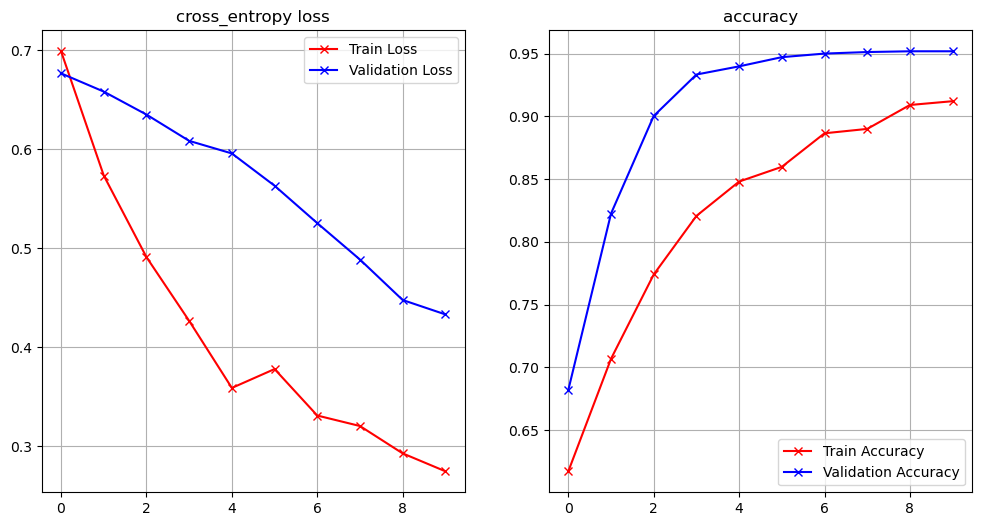

In [36]:
def plot_loss_accuracy(hist_1):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(hist_1.history["loss"],'r-x', label="Train Loss")
    ax.plot(hist_1.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(hist_1.history["binary_accuracy"],'r-x', label="Train Accuracy")
    ax.plot(hist_1.history["val_binary_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)


plot_loss_accuracy(hist)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


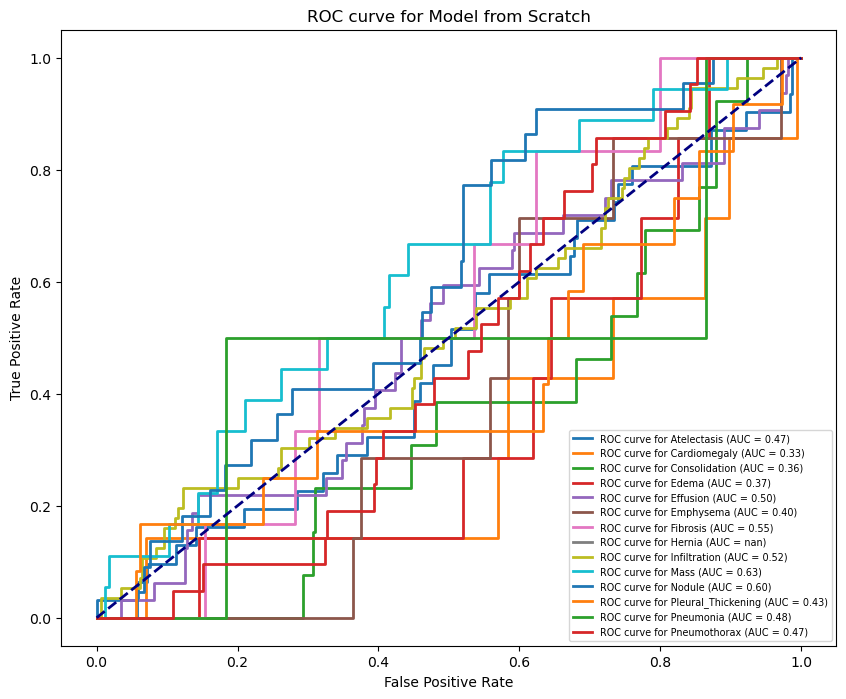

In [96]:
class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 
               'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 
               'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

def plot_roc_auc(predict, model_name, class_names):
    num_classes = len(class_names)
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], predict[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='ROC curve for {} (AUC = {:.2f})'.format(class_names[i], roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    xlim=[-0.01, 1.01], 
    ylim=[-0.01, 1.01]
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for {}'.format(model_name))
    plt.legend(loc="lower right", fontsize='x-small')
    plt.show()

plot_roc_auc(predict, 'Model from Scratch', class_names)

## Using VGG16 as the Pre-trained model.

In [37]:
pt_model = vgg16.VGG16(weights='imagenet')
pt_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Replace the output layer of VGG16 model with a shape of 1000 to 14
pt_model = Model(inputs=pt_model.input, outputs=pt_model.layers[-2].output)
output_layer = Dense(14, activation='sigmoid')(pt_model.output)

# Create a new model then add the modified output layer
pt_model = Model(inputs=pt_model.input, outputs=output_layer)
pt_model.summary()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 14)             │        57,358 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,317,902 (512.38 MB)

 Trainable params: 134,317,902 (512.38 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Compile new model made from modified VGG16 Architecture
pt_model.compile(optimizer=Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['binary_accuracy'])
pt_hist = pt_model.fit(train_gen, epochs=6, verbose=1, batch_size=batch_size,
                       steps_per_epoch=30, validation_data=(X_test, y_test), callbacks=earlystop)

Epoch 1/6
30/30 ━━━━━━━━━━━━━━━━━━━━ 719s 23s/step - binary_accuracy: 0.8829 - loss: 7.7900 - val_binary_accuracy: 0.9524 - val_loss: 0.1892
Epoch 2/6
30/30 ━━━━━━━━━━━━━━━━━━━━ 708s 23s/step - binary_accuracy: 0.9510 - loss: 0.1916 - val_binary_accuracy: 0.9524 - val_loss: 0.1781
Epoch 3/6
30/30 ━━━━━━━━━━━━━━━━━━━━ 683s 23s/step - binary_accuracy: 0.9497 - loss: 0.1895 - val_binary_accuracy: 0.9524 - val_loss: 0.1837
Epoch 4/6
30/30 ━━━━━━━━━━━━━━━━━━━━ 666s 22s/step - binary_accuracy: 0.9543 - loss: 0.1753 - val_binary_accuracy: 0.9524 - val_loss: 0.1833
Epoch 5/6
30/30 ━━━━━━━━━━━━━━━━━━━━ 300s 10s/step - binary_accuracy: 0.9520 - loss: 0.1743 - val_binary_accuracy: 0.9524 - val_loss: 0.1818
Epoch 6/6
30/30 ━━━━━━━━━━━━━━━━━━━━ 708s 23s/step - binary_accuracy: 0.9518 - loss: 0.1800 - val_binary_accuracy: 0.9524 - val_loss: 0.1864


In [41]:
pt_score = pt_model.evaluate(X_test, y_test, verbose=0)
print('CNN from Scratch Test loss:', pt_score[0])
print('CNN from Scratch Test accuracy:', pt_score[1])

CNN from Scratch Test loss: 0.18702197074890137
CNN from Scratch Test accuracy: 0.9523809552192688


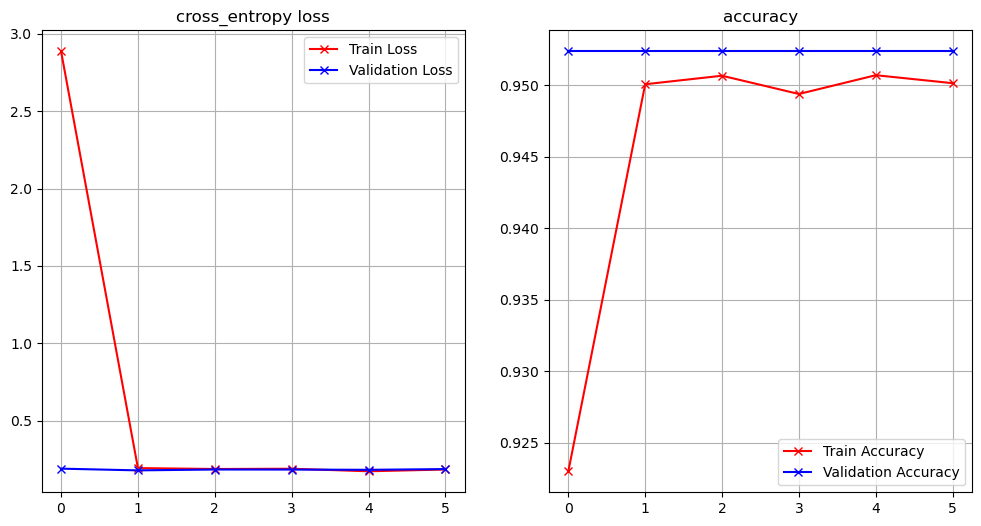

In [42]:
plot_loss_accuracy(pt_hist)

11/11 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


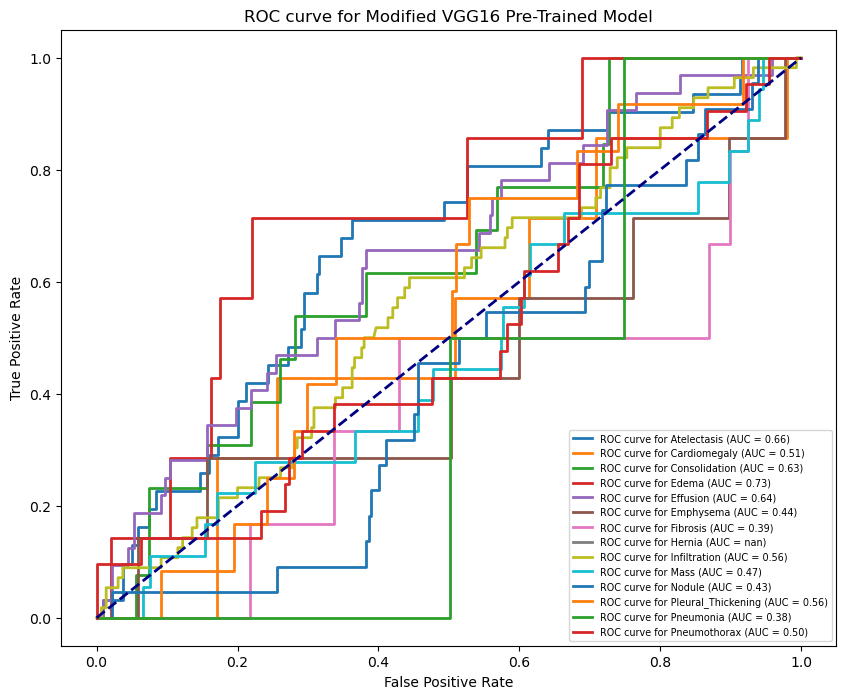

In [97]:
pt_predict = pt_model.predict(X_test)
plot_roc_auc(pt_predict, 'Modified VGG16 Pre-Trained Model', class_names)